# Using PyTorch Lightning and MLFlow with Rockpool

## Set up task

In [17]:
import tonic
from tonic.datasets import SMNIST
from tonic import CachedDataset
# from tonic.transforms import Compose, ToFrame, Downsample, NumpyAsType, Repeat
# from tonic.collation import PadTensors
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import torch
# import numpy as np

from rockpool import TSEvent

import sys
!{sys.executable} -m pip install --quiet matplotlib
import matplotlib.pyplot as plt

from dataclasses import dataclass, field

In [35]:
class ToSpike:
    def __init__(self, n_neurons):
        self.n_neurons = n_neurons
#         self.bins = np.linspace(-1, 1, num=self.n_neurons+1)
    def __call__(self, sample):
        sample = sample.reshape(28*28)
#         sample_diff = torch.unsqueeze(sample[0][1:]-sample[0][:-1], 0) 
#         sample_diff = np.expand_dims(sample[0][1:]-sample[0][:-1], 0) 
        sample_diff = sample[1:]-sample[:-1]
        spikes = torch.zeros((self.n_neurons, sample_diff.shape[0]))
#         indices = np.digitize(sample_diff, self.bins, right=True)
#         indices -= 1
#         spikes[indices[0], np.arange(sample_diff.shape[1])] = 1
        spikes[0, sample_diff > 0] = torch.round(sample_diff[sample_diff > 0]*10)
        spikes[1, sample_diff < 0] = torch.round(torch.abs(sample_diff[sample_diff < 0])*10)
        return spikes.T

In [36]:
dt = 1e-3
n_neurons = 2
batch_size = 300

In [37]:
# - Create dataset and dataloader for Spiking Heidelberg Digits
data_transform_original = transforms.Compose([
    transforms.ToTensor(),
#     transforms.Normalize((0.1307,), (0.3081,)),
])
data_transform = transforms.Compose([
    transforms.ToTensor(),
#     transforms.Normalize((0.1307,), (0.3081,)),
#     transforms.Lambda(lambda x: x.view(1, -1)), # unrolls 28x28 to one sequence of length 784
    ToSpike(n_neurons),
#     transforms.ToTensor()
])

ds_original = datasets.MNIST('./data', train=True, transform=data_transform_original)
ds_train = datasets.MNIST('./data', train=True, transform=data_transform)#, target_transform=target_transform)
ds_test = datasets.MNIST('./data', train=False, transform=data_transform)#, target_transform=target_transform)
    
dl_train = DataLoader(ds_train, num_workers = 8, batch_size = batch_size)
dl_test = DataLoader(ds_test, num_workers = 8, batch_size = batch_size)

torch.Size([783, 2])


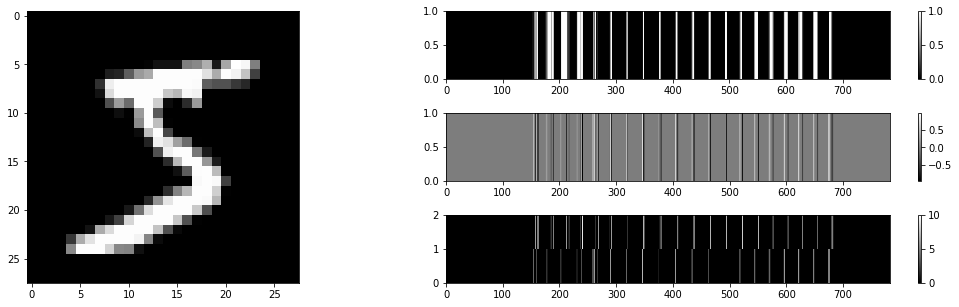

In [38]:
sample_mnist, target_mnist = ds_original[0]
# a sample of sequential MNIST
sample_seq_mnist = sample_mnist[0].reshape(sample_mnist.shape[1]*sample_mnist.shape[2])
# a sample of spiking sequential MNIST
sample_smnist, target_smnist = ds_train[0]
print(sample_smnist.shape)
# difference between pixel and previous pixel
sample_seq_mnist_diff = torch.unsqueeze(sample_seq_mnist[1:]-sample_seq_mnist[:-1], 0) 
nx, ny = 3, 2
fig = plt.figure(figsize=(20, 5))
fig.subplots_adjust(wspace=0.01, hspace=0.5)
ax = [plt.subplot2grid((nx, ny), (0, 0), rowspan=3), 
      plt.subplot2grid((nx, ny), (0, 1)), plt.subplot2grid((nx, ny), (1, 1)), plt.subplot2grid((nx, ny), (2, 1))]
ax[0].imshow(sample_mnist[0], cmap='gray')#, vmin=0, vmax=255)
c = ax[3].pcolor(sample_smnist.T, cmap='gray')
fig.colorbar(c, ax=ax[3])
c = ax[2].pcolor(sample_seq_mnist_diff, cmap='gray')
fig.colorbar(c, ax=ax[2])
c = ax[1].pcolor(torch.unsqueeze(sample_seq_mnist,0), cmap='gray')
fig.colorbar(c, ax=ax[1])

In [39]:
# - Record the number of input channels
N_in = n_neurons
N_hidden = 300

# - Number of output classes is fixed
N_out = 10

## Define network and model

In [40]:
from rockpool.nn.modules import LIFTorch, LinearTorch
from rockpool.nn.combinators import Sequential, Residual

from torch.nn import functional as F

import pytorch_lightning as pl

import mlflow

In [41]:
# - Define a PyTorch Lightning module
class Model(pl.LightningModule):
    def __init__(self):
        super().__init__()
        self.net = Sequential(
            LinearTorch((N_in, N_hidden), has_bias = False),
            LIFTorch(N_hidden, dt=dt, tau_mem=1., tau_syn=1., has_bias = True, bias = 1., device='cuda'),
            LinearTorch((N_hidden, N_out), has_bias = False),
            LIFTorch(N_out, dt=dt, tau_mem=100., tau_syn=1., has_bias = True, bias = 1.,  device='cuda'),
        ).to_torch()
    
    def forward(self, x):
        return self.net(x)
    
    def _shared_eval_step(self, batch):
        x, y = batch
        y_hat = self(x.float())
        y = y.unsqueeze(1).repeat(1, y_hat.shape[1])
        
        crit = F.cross_entropy(y_hat.permute(0, 2, 1), y)        
        reg = torch.mean((1 - x) ** 2)
        loss = crit + reg

        return loss
        
    def training_step(self, batch, batch_idx):
        loss = self._shared_eval_step(batch)
        self.log("train_loss", loss)
        return loss
    
    def validation_step(self, batch, batch_idx):
        loss = self._shared_eval_step(batch)
        self.log("val_loss", loss)
        return loss
    
    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=0.02)

In [42]:
# - Instantiate the model
model = Model().float()
dl_train_iter = iter(dl_train) 
inputs, targets = next(dl_train_iter) 
print(inputs.shape)
# model(inputs.T)

torch.Size([300, 783, 2])


In [43]:
# - Initialize a trainer
trainer = pl.Trainer(
    callbacks = [pl.callbacks.ModelCheckpoint()],
    max_epochs=2, gpus=1
)

# - Enable autologging
mlflow.pytorch.autolog()

# - Create a new MLFlow run and fit the model
with mlflow.start_run() as run:
    trainer.fit(model, dl_train, dl_test)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
2021/12/20 15:20:43 WARNING mlflow.utils.autologging_utils: You are using an unsupported version of pytorch. If you encounter errors during autologging, try upgrading / downgrading pytorch to a supported version, or try upgrading MLflow.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name | Type            | Params
-----------------------------------------
0 | net  | TorchSequential | 3.9 K 
-----------------------------------------
3.9 K     Trainable params
0         Non-trainable params
3.9 K     Total params
0.016     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

2021/12/20 15:35:55 WARNING mlflow.utils.requirements_utils: Found torch version (1.9.1+cu111) contains a local version label (+cu111). MLflow logged a pip requirement for this package as 'torch==1.9.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2021/12/20 15:35:55 WARNING mlflow.utils.requirements_utils: Found torchvision version (0.10.1+cu111) contains a local version label (+cu111). MLflow logged a pip requirement for this package as 'torchvision==0.10.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2021/12/20 15:36:02 WARNING mlflow.utils.requirements_utils: Found jaxlib version (0.1.73+cuda11.cudnn82) contains a local version label (+cuda11.cudnn82). MLflow logged a pip requirement for this package as 'jaxlib==0.1.73' without t

In [16]:
sample, target = ds_train[23]
plt.plot(model(torch.from_numpy(sample.reshape(1, -1, N_in))).detach().numpy().squeeze());
plt.title(target)

TypeError: expected np.ndarray (got Tensor)

In [ ]:
out, _, r_d = model.net.evolve(torch.from_numpy(sample.reshape(1, -1, N_in)), record = True)

In [ ]:
plt.imshow(r_d['0_LinearTorch_output'].squeeze().detach().numpy().T, aspect = 'auto')

In [ ]:
plt.imshow(r_d['1_LIFTorch']['Vmem'].detach().numpy().squeeze().T, aspect='auto')

In [ ]:
plt.imshow(r_d['1_LIFTorch_output'].squeeze().detach().numpy().T, aspect = 'auto')

In [ ]:
plt.imshow(r_d['3_LIFTorch_output'].squeeze().detach().numpy().T, aspect = 'auto')